# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [15]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

In [16]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

In [17]:
# Read and save test images to array
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [18]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [19]:
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [20]:
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [21]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

In [22]:
# Not used
from sklearn.linear_model import LinearRegression

def find_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    points_x = [[point[0]] for point in points]
    points_y = [point[1] for point in points]
    # points_x_print = [point[0] for point in points]
    # print("X points: ", points_x, "Length: ", len(points_x))
    # print("X points: ", points_x_print, "Length: ", len(points_x))
    # print("Y points: ", points_y, "Length: ", len(points_y))

    # Fit points to LinearRegression line
    clf = LinearRegression().fit(points_x, points_y)

    # Get parameters from line
    coef = clf.coef_[0]
    intercept = clf.intercept_
    print("Coefficients: ", coef, "Intercept: ", intercept)
    return coef, intercept

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [23]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 '1479425444683294213.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

run your solution on all test_images and make copies into the test_images directory).

### Pipeline

Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

Slope & intercept:  [[0.6214285714285714, 7.921428571428578], [0.6512455516014235, -4.185053380782904], [0.6507177033492823, -4.545454545454504]]
Slope:  0.6411306087930924 Intercept:  -0.26969311826961
Slope & intercept:  [[-0.6713286713286714, 630.1118881118881], [-0.7222222222222222, 655.8333333333334], [-0.6733333333333333, 631.7333333333333], [-0.6973684210526315, 646.7631578947369]]
Slope:  -0.6910631619842146 Intercept:  641.1104281683229
Coef:  0.6411306087930924 Intercept:  -0.26969311826961 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (960, 615)
Coef:  -0.6910631619842146 Intercept:  641.1104281683229 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (0, 641)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ...,
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ...,
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ...,
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ...,

       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ...,
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ...,
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ...,
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144, 146]]

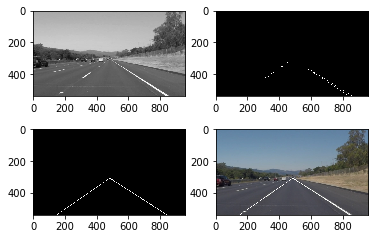

In [24]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    return final_image

draw_lane_lines(test_images[0])

## Testing the Pipeline on the test_images

Slope & intercept:  [[0.6214285714285714, 7.921428571428578], [0.6512455516014235, -4.185053380782904], [0.6507177033492823, -4.545454545454504]]
Slope:  0.6411306087930924 Intercept:  -0.26969311826961
Slope & intercept:  [[-0.6713286713286714, 630.1118881118881], [-0.7222222222222222, 655.8333333333334], [-0.6733333333333333, 631.7333333333333], [-0.6973684210526315, 646.7631578947369]]
Slope:  -0.6910631619842146 Intercept:  641.1104281683229
Coef:  0.6411306087930924 Intercept:  -0.26969311826961 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (960, 615)
Coef:  -0.6910631619842146 Intercept:  641.1104281683229 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (0, 641)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ...,
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ...,
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ...,
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ...,

       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ...,
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ...,
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ...,
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144, 146]]

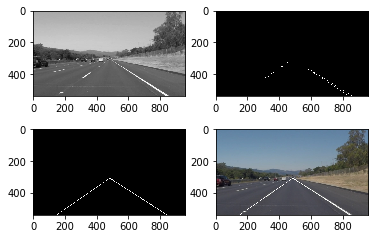

In [25]:
draw_lane_lines(test_images[0])

Slope & intercept:  [[0.5535055350553506, 41.50553505535049], [0.5748299319727891, 33.874149659863974], [0.5774058577405857, 31.3305439330544], [0.5528455284552846, 41.097560975609724]]
Slope:  0.5646467133060025 Intercept:  36.95194740596965
Slope & intercept:  [[-0.8106508875739645, 698.7100591715977], [-0.7555555555555555, 671.5555555555555], [-0.7054263565891473, 653.6744186046512], [-0.7833333333333333, 688.6]]
Slope:  -0.7637415332630001 Intercept:  678.1350083329511
Coef:  0.5646467133060025 Intercept:  36.95194740596965 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (960, 579)
Coef:  -0.7637415332630001 Intercept:  678.1350083329511 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ...,

       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ...,
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ...,
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ...,
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,  70]]

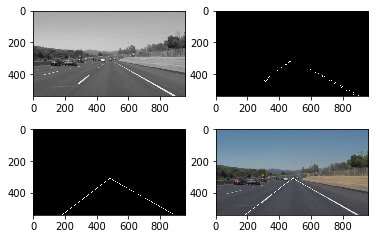

In [26]:
draw_lane_lines(test_images[1])

Slope & intercept:  [[0.6026490066225165, 25.145695364238406], [0.573170731707317, 38.04878048780489], [0.5777027027027027, 32.5101351351351], [0.5560344827586207, 49.504310344827616]]
Slope:  0.5689693057228801 Intercept:  40.021075322589205
Slope & intercept:  [[-0.7263513513513513, 655.2162162162163], [-0.7542372881355932, 671.9491525423729], [-0.7580645161290323, 673.6935483870968], [-0.7241379310344828, 653.1379310344828]]
Slope:  -0.7406977716626149 Intercept:  663.4992120450422
Coef:  0.5689693057228801 Intercept:  40.021075322589205 intersection_x:  476.0584941686938
Point one:  (476, 310) Point two:  (960, 586)
Coef:  -0.7406977716626149 Intercept:  663.4992120450422 intersection_x:  476.0584941686938
Point one:  (476, 310) Point two:  (0, 663)


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ...,
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ...,
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ...,
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ...,

       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ...,
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ...,
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ...,
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,  72]]

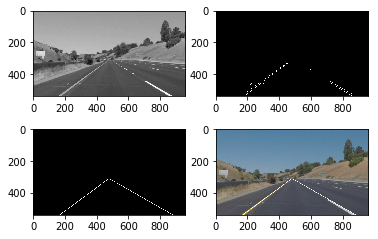

In [27]:
draw_lane_lines(test_images[2])

negative_slope_points still empty
Slope & intercept:  [[1.1111111111111112, -198.55555555555554], [1.0392156862745099, -173.6274509803922], [1.146067415730337, -216.86516853932585], [1.0333333333333334, -168.90000000000003], [0.9712230215827338, -132.92805755395682]]
Slope:  1.0601901136064051 Intercept:  -178.1752465258461
Slope & intercept:  []
Slope:  nan Intercept:  nan
Coef:  1.0601901136064051 Intercept:  -178.1752465258461 intersection_x:  nan


ValueError: cannot convert float NaN to integer

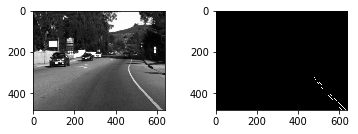

In [28]:
draw_lane_lines(test_images[3])

Slope & intercept:  [[0.6490384615384616, -4.8125], [0.5970873786407767, 22.883495145631116], [0.5786516853932584, 36.915730337078685]]
Slope:  0.6082591751908323 Intercept:  18.3289084942366
Slope & intercept:  [[-0.6743421052631579, 631.0592105263158], [-0.7246963562753036, 653.9676113360324], [-0.6888888888888889, 634.6444444444444], [-0.726027397260274, 653.7123287671233], [-0.6741935483870968, 630.7129032258065]]
Slope:  -0.6976296592149442 Intercept:  640.8192996599444
Coef:  0.6082591751908323 Intercept:  18.3289084942366 intersection_x:  476.6794651774183
Point one:  (476, 308) Point two:  (960, 602)
Coef:  -0.6976296592149442 Intercept:  640.8192996599444 intersection_x:  476.6794651774183
Point one:  (476, 308) Point two:  (0, 640)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ...,
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ...,
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ...,
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ...,

       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ...,
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ...,
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ...,
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146, 153]]

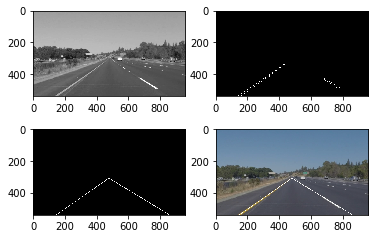

In [29]:
draw_lane_lines(test_images[4])

Slope & intercept:  [[0.5986622073578596, 22.35451505016721], [0.5741444866920152, 32.08745247148289], [0.5782608695652174, 28.39565217391305], [0.6014234875444839, 18.971530249110344]]
Slope:  0.5881227627898941 Intercept:  25.452287486168373
Slope & intercept:  [[-0.7525773195876289, 671.4536082474226], [-0.7813620071684588, 689.584229390681], [-0.748792270531401, 671.1835748792271], [-0.765625, 686.734375], [-0.8, 697.6], [-0.8070175438596491, 696.3684210526316], [-0.8222222222222222, 709.2666666666667], [-0.8333333333333334, 707.0]]
Slope:  -0.7888662120878367 Intercept:  691.1488594045786
Coef:  0.5881227627898941 Intercept:  25.452287486168373 intersection_x:  483.4436470179585
Point one:  (483, 309) Point two:  (960, 590)
Coef:  -0.7888662120878367 Intercept:  691.1488594045786 intersection_x:  483.4436470179585
Point one:  (483, 309) Point two:  (0, 691)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ...,
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ...,
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ...,
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ...,

       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ...,
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ...,
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ...,
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,  75]]

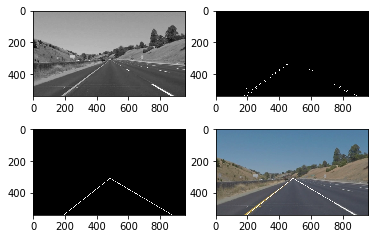

In [30]:
draw_lane_lines(test_images[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lane_lines(image)
    print(result.shape)
    return result

Let's try the one with the solid white lane on the right first ...

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768], [0.5875, 27.149999999999977]]
Slope:  0.6197824892258337 Intercept:  7.025616943794162
Slope & intercept:  [[-0.752, 665.904], [-0.7019607843137254, 642.9686274509804], [-0.7254098360655737, 649.6516393442623], [-0.7251461988304093, 647.6023391812865], [-0.7068965517241379, 647.7241379310344]]
Slope:  -0.7222826741867692 Intercept:  650.7701487815127
Coef:  0.6197824892258337 Intercept:  7.025616943794162 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (960, 602)
Coef:  -0.7222826741867692 Intercept:  650.7701487815127 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (0, 650)
(540, 960, 3)
Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768], [

OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file white.mp4:

 b"Unrecognized option 'preset'.\nError splitting the argument list: Option not found\n"

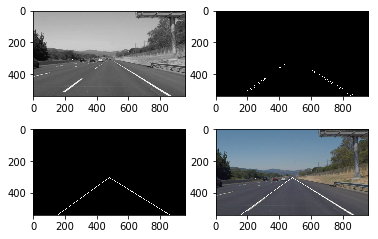

In [33]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768], [0.5875, 27.149999999999977]]
Slope:  0.6197824892258337 Intercept:  7.025616943794162
Slope & intercept:  [[-0.752, 665.904], [-0.7019607843137254, 642.9686274509804], [-0.7254098360655737, 649.6516393442623], [-0.7251461988304093, 647.6023391812865], [-0.7068965517241379, 647.7241379310344]]
Slope:  -0.7222826741867692 Intercept:  650.7701487815127
Coef:  0.6197824892258337 Intercept:  7.025616943794162 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (960, 602)
Coef:  -0.7222826741867692 Intercept:  650.7701487815127 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (0, 650)
(540, 960, 3)
Moviepy - Building video yellow.mp4.
Moviepy - Writing video yellow.mp4

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768],

OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file yellow.mp4:

 b"Unrecognized option 'preset'.\nError splitting the argument list: Option not found\n"

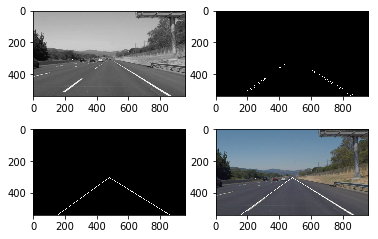

In [21]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Pipeline Description

#### Pipeline Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

#### Focus on Step 7 (Drawing lines extrapolated from line segments)
The time I spent the most time on was Step 7, drawing lines extrapolated from line segments. This step required custom code in addition to the helper functions provided.
1. Divide the hough line segments into those with positive slopes (left lane line) and negative slopes (negative lane line). Take only those with length greater than 50 to remove noise.
    * For each Hough line segment (two points), if (1) the slope of the line is positive and (2) if the line segment length is greater than 50 pixels (length chosen by observation), add the slope and intercept to an array `positive_slope_intercept`. I also added the clause that if the array is empty, we should go through the Hough lines again and add at least one pair of points to the array `positive_slope_intercept`. 
    * Do the same for Hough line segments with negative slope.
    * Line segments with positive slope belong to the negative 
2. Fit a line to the points belonging to the left lane line and to the points belonging to the right lane line separately using `find_line_fit`. Get the intercept and coefficient of the fitted lines.
    * If there is only one slope and intercept, return those.
    * Remove noise: remove points with slope not within 1.5 standard deviations of the mean. (1.5 chosen arbitrarily) This may fail if there is only one datapoint (it failed on one frame of the yellow lane line video), which is why I added the clause above.
    * Take the estimate of the slope and intercept to be that of the remaining values.
3. Calculate where the lane lines intersect.
4. Draw the lines from the intersection point to the bottom of the image.


### Shortcomings

* There are a few instances in the yellow lane line video where the lane lines are marked incorrectly. The error is always (to my knowledge) in the lane line that is not solid.
    * I tried adjusting the Hough parameters further but this often resulted in no hough lines being created in at least one frame in the yellow lane line video.
* Image dimensions were hard-coded in at least one case.
* If the lane lines are not straight lines but have high curvature, this algorithm may give weird results.
* The algorithm was trained on a specific type of lane and type of day (daytime, moderately bright with no snow, rain or hail), so it may not generalise well.

### Possible Improvements

* Tune Hough transform parameters more systematically with more test images instead of by 'feel'.
* Currently the lane lines are drawn in solid white. It would be nice if they were drawn in thicker, semi-transparent red (say).

Reflection describes the current pipeline, identifies its potential shortcomings and suggests possible improvements. There is no minimum length. Writing in English is preferred but you may use any language.



I have included some debugging plots below for fun.


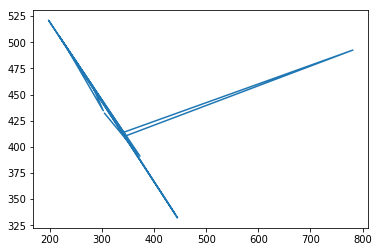

In [23]:
# Debugging plot 1: Plotting the midpoints of the Hough line segments
# for a test image to see why the final line plotted was wrong.
plt.plot([305.0, 373.0, 229.0, 302.5, 281.5, 197.5, 445.0, 339.5, 781.5, 346.0, 217.0, 439.5],
         [432.0, 391.0, 497.5, 434.5, 458.5, 521.0, 332.0, 413.5, 492.5, 410.5, 506.5, 336.5])
plt.show()

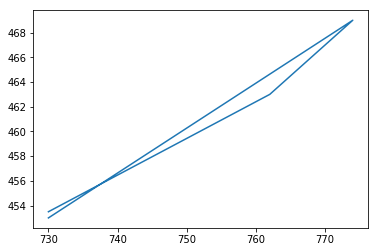

In [24]:
# Debugging plot 2: Plotting the midpoints of the Hough line segments
# for a test image to see why the final line plotted was wrong.
plt.plot([730.0, 762.0, 774.0, 730.0],[453.5, 463.0, 469.0, 453.0])
plt.show()

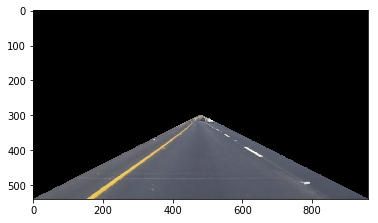

In [25]:
# Debugging mask
border = 80
imshape = [540, 960]
vertices = np.array([[(0,imshape[0]),(475, 300), (485, 300), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)    
plt.imshow(region_of_interest(test_images[5], vertices))

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

                                                              
t:   0%|          | 1/221 [11:03<40:32:26, 663.39s/it, now=None]
                                                                
t:   0%|          | 1/221 [09:52<36:11:34, 592.25s/it, now=None]

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768], [0.5875, 27.149999999999977]]
Slope:  0.6197824892258337 Intercept:  7.025616943794162
Slope & intercept:  [[-0.752, 665.904], [-0.7019607843137254, 642.9686274509804], [-0.7254098360655737, 649.6516393442623], [-0.7251461988304093, 647.6023391812865], [-0.7068965517241379, 647.7241379310344]]
Slope:  -0.7222826741867692 Intercept:  650.7701487815127
Coef:  0.6197824892258337 Intercept:  7.025616943794162 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (960, 602)
Coef:  -0.7222826741867692 Intercept:  650.7701487815127 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (0, 650)
(540, 960, 3)
Moviepy - Building video extra.mp4.
Moviepy - Writing video extra.mp4

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768], [

OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file extra.mp4:

 b"Unrecognized option 'preset'.\nError splitting the argument list: Option not found\n"

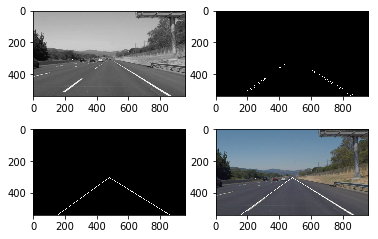

In [26]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Misc